In [ ]:
<a href="https://colab.research.google.com/github/tvml/ml2324/blob/master/codici/linear-regression_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Regression

In [ ]:
#!pip install torchmetrics

In [ ]:
#!pip install torchinfo

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils import data
from torch import nn
import torch.nn.functional as F
from torchmetrics.functional import r2_score
from torchinfo import summary
from d2l import torch as d2l

In [2]:
class History:
    """Accumulates values in a dictionary of sequences."""
    def __init__(self, keys):
        self.data = {}
        self.keys = keys
        for k in self.keys:
            self.data[k] = []

    def add(self, *args):
        for k,a in zip(self.keys, args):
            self.data[k].append(a)

    def sums(self):
        return {k: sum(self.data[k]) for k in self.keys}

    def merge(self, d):
        for k in self.keys:
            self.data[k].extend(d[k])

    def __getitem__(self, k):
        return self.data

### Generating a synthetic dataset

In [3]:
def synthetic_data(w, b, noise_std, num_examples):
    """Generate y = Xw + b + noise."""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, noise_std, y.shape)
    return X, y.reshape((-1, 1))

In [4]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 0.01, 10000)

## Reading the Dataset


Create data loaders for synthetic train and test sets

In [5]:
def load_array(data_arrays, batch_size, is_train=True):
    """Construct a PyTorch data iterator."""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [6]:
batch_size = 100

loaders = {'train' : load_array(synthetic_data(true_w, true_b, 0.01, 10000), batch_size),
            'test'  : load_array(synthetic_data(true_w, true_b, 0.01, 3000), batch_size, is_train=False)}

In [7]:
batch = next(iter(loaders['train']))
print(batch[0][:10])
print(batch[1][:10])

tensor([[-0.5033, -0.5157],
        [-0.1319, -0.8306],
        [-1.8648,  1.5496],
        [-1.3231, -0.5911],
        [-1.5226,  0.0907],
        [-0.1032, -1.9000],
        [-1.7376,  1.0676],
        [ 0.2402,  2.8941],
        [-1.8400, -0.9662],
        [-0.2816,  0.2237]])
tensor([[ 4.9430],
        [ 6.7624],
        [-4.8014],
        [ 3.5834],
        [ 0.8461],
        [10.4561],
        [-2.9082],
        [-5.1833],
        [ 3.8109],
        [ 2.8746]])


Define a linear model as a neural network with a single layer and no (that is, identity) activation function

In [8]:
class LinearRegression(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.dim = d
        self.layer = nn.Linear(self.dim, 1)   
        self._init_weights()
        
    def _init_weights(self):
        self.layer.weight.data.normal_(0, 0.01)
        self.layer.bias.data.fill_(0)

    def forward(self, x):
         out = self.layer(x)
         return out 

In [9]:
loss_func = nn.MSELoss()

In [10]:
model = LinearRegression(2)
optimizer = torch.optim.SGD(model.parameters(), lr=0.03)

In [11]:
summary(model, input_size=(batch_size, 2))

Layer (type:depth-idx)                   Output Shape              Param #
LinearRegression                         [100, 1]                  --
├─Linear: 1-1                            [100, 1]                  3
Total params: 3
Trainable params: 3
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [12]:
def rmse(preds, targets):
    """Compute the rmse of predictions."""
    return torch.sqrt(torch.mean((preds-targets)**2)).detach()

In [13]:
def evaluate_rmse_rsa(net, data_iter):
    """Compute the rmse and rsa for a model on a dataset."""
    net.eval()
    h_test = History(['rmse', 'rsa', 'n_items'])  # No. of correct predictions, no. of predictions
    with torch.no_grad(): # Gradients must not be computed
        count = 0
        for X, y in data_iter:
            count += 1
            if count%10 == 0:
                print('x', end='')
            h_test.add(rmse(net(X), y), r2_score(net(X).detach(), y), len(y))
        s = h_test.sums()
    print(' ')
    return s['rmse']/s['n_items'], s['rsa']/s['n_items']

In [14]:
# l0, l1, l2, ll, lr =[], [], [], [], []
# e = true_w - model.layer.weight.data.reshape(true_w.shape)
# l0.append(true_b - model.layer.bias.data)
# l1.append(e[0])
# l2.append(e[1])
# #print(f'error in estimating w: {true_w - model.layer.weight.data.reshape(true_w.shape)}')
# #print(f'error in estimating b: {true_b - model.layer.bias.data}')
# count = 0
# for X,y in loaders['train']:
#     count += 1
#     #print(f'count: {count}')
#     y_hat = model(X)
#     loss = loss_func(y_hat, y)
#     ll.append(loss.data)
#     lr.append(rmse(y_hat, y).data)
#     #print(f'loss: {loss.data}')
#     #print(f'rmse: {rmse(y_hat, y)}')
#     optimizer.zero_grad()
#     loss.backward()
#     #print(f'weight gradient: {model.layer.weight.grad}')
#     #print(f'bias gradient: {model.layer.bias.grad}')
#     optimizer.step()
#     e = true_w - model.layer.weight.data.reshape(true_w.shape)
#     l0.append(true_b - model.layer.bias.data)
#     l1.append(e[0])
#     l2.append(e[1])
#     #print(f'error in estimating w: {true_w - model.layer.weight.data.reshape(true_w.shape)}')
#     #print(f'error in estimating b: {true_b - model.layer.bias.data}')

In [ ]:
#plt.plot(lr)

In [16]:
def train_epoch(model, train_iter, loss_func, optimizer): 
    model.train()  # Set the model to training mode
    h_epoch = History(['loss', 'rmse', 'rsa', 'n_examples']) # Training loss, no. of correct predictions, no. of examples
    count = 0
    for X, y in train_iter:
        count += 1
        if count%10 == 0:
            print('.', end='')
        # Compute predictions
        y_hat = model(X)
        # Compute loss
        loss = loss_func(y_hat, y)
        optimizer.zero_grad()
        # Comoptimizer.zero_grad()pute gradients
        loss.backward()
        # Update parameters
        optimizer.step()
        h_epoch.add(float(loss), rmse(y_hat, y), r2_score(y_hat, y).detach(), len(y))
    # Return training loss and training accuracy
    s = h_epoch.sums()
    return s['loss']/s['n_examples'], s['rmse']/s['n_examples'], s['rsa']/s['n_examples'], h_epoch


def train(net, loaders, loss_func, num_epochs, updater, report=False):
    h_batch = History(['loss', 'rmse', 'rsa', 'n_examples'])
    h_train = History(['training_loss', 'train_rmse', 'train_rsa', 'test_rmse', 'test_rsa']) # Avg. training loss, test loss
    for epoch in range(num_epochs):
        print(f'Epoch #{epoch+1}')
        # train model for one epoch
        train_loss, train_rmse, train_rsa, h_epoch = train_epoch(net, loaders['train'], loss_func, updater)
        # evaluate rmse and rsa on test set
        test_rmse, test_rsa = evaluate_rmse_rsa(net, loaders['test'])
        if report:
            print(f' Loss {train_loss:3.4f}, Training set rmse {train_rmse:1.4f}, Test set rmse {test_rmse:1.4f}, Training set rsa {train_rsa:1.4f}, Test set rsa {test_rsa:1.4f}')
        else:
            print('\n')
        h_train.add(train_loss, train_rmse, train_rsa, test_rmse, test_rsa)
        h_batch.merge(h_epoch.data)
    return h_train, h_batch

In [17]:
num_epochs=5
h, h_batch = train(model, loaders, loss_func, num_epochs, optimizer, report=True)

Epoch #1
..........xxx 
 Loss 0.0000, Training set rmse 0.0001, Test set rmse 0.0001, Training set rsa 0.0100, Test set rsa 0.0100
Epoch #2
..........xxx 
 Loss 0.0000, Training set rmse 0.0001, Test set rmse 0.0001, Training set rsa 0.0100, Test set rsa 0.0100
Epoch #3
..........xxx 
 Loss 0.0000, Training set rmse 0.0001, Test set rmse 0.0001, Training set rsa 0.0100, Test set rsa 0.0100
Epoch #4
..........xxx 
 Loss 0.0000, Training set rmse 0.0001, Test set rmse 0.0001, Training set rsa 0.0100, Test set rsa 0.0100
Epoch #5
..........xxx 
 Loss 0.0000, Training set rmse 0.0001, Test set rmse 0.0001, Training set rsa 0.0100, Test set rsa 0.0100


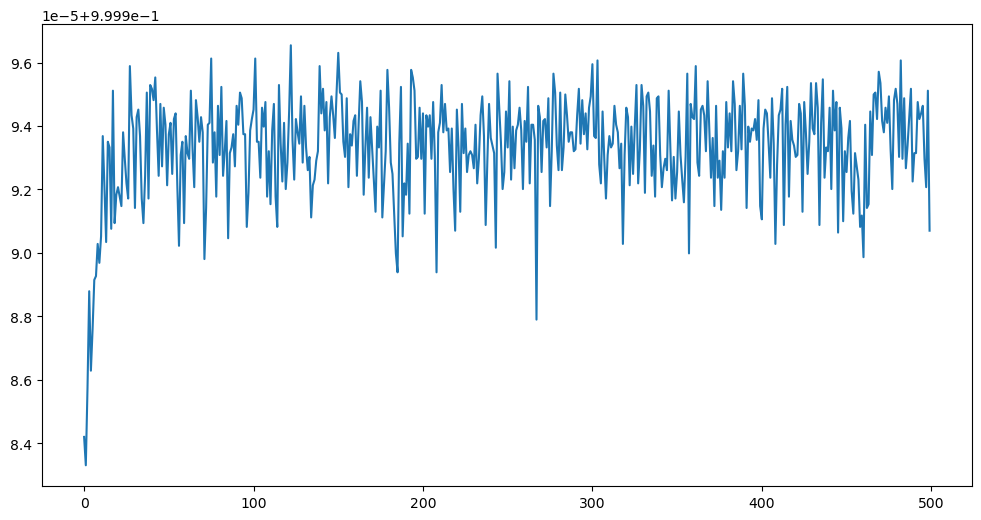

In [18]:
plt.figure(figsize=(12,6))
plt.plot([x.item() for x in h_batch.data['rsa']])
plt.show()

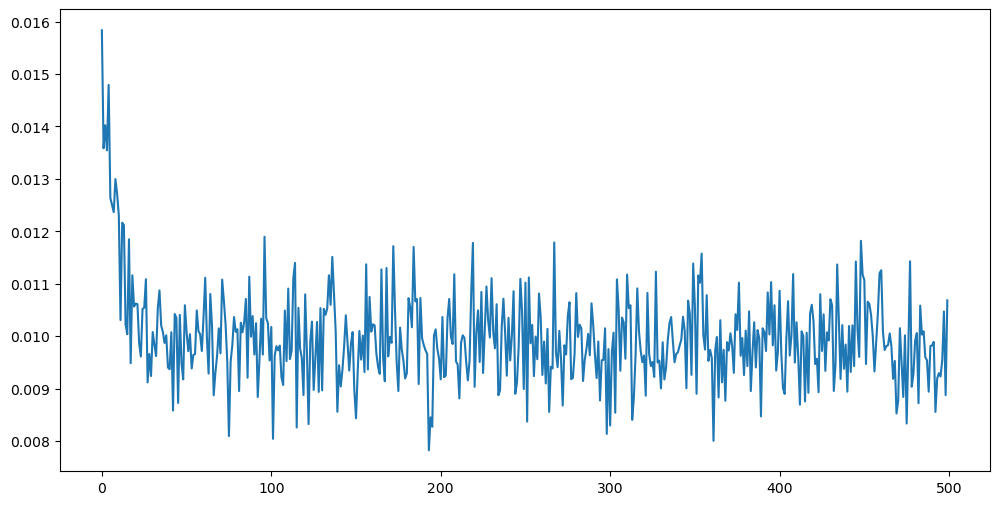

In [19]:
plt.figure(figsize=(12,6))
plt.plot([x.item() for x in h_batch.data['rmse']])
plt.show()

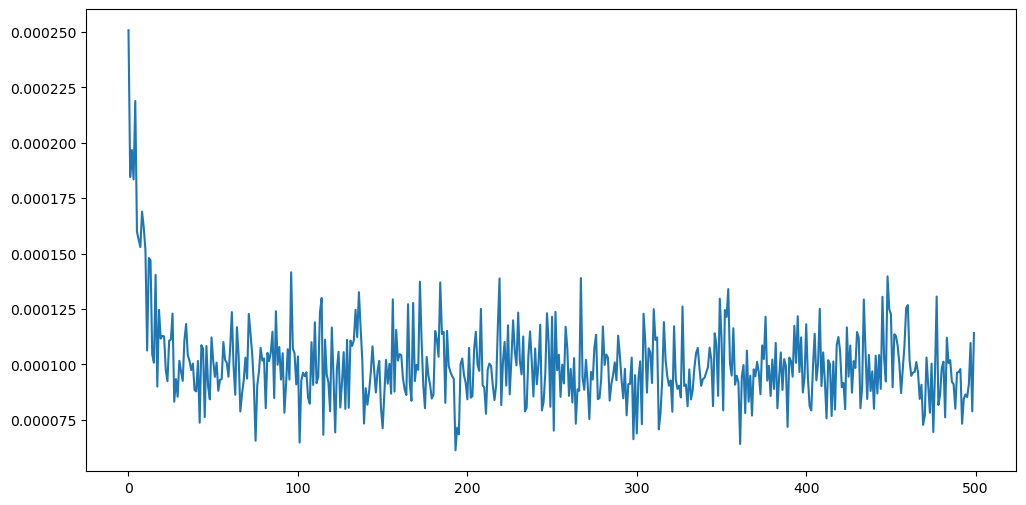

In [20]:
plt.figure(figsize=(12,6))
plt.plot(h_batch.data['loss'])
plt.show()

In [21]:
print(f'Real coefficients: {true_w[0]:3.3f}, {true_w[1]:3.3f}, {true_b:3.3f}')
print(f'Estimated coefficients: {model.layer.weight.data[0][0]:3.3f}, {model.layer.weight.data[0][1]:3.3f}, {model.layer.bias.data.item():3.3f}')

Real coefficients: 2.000, -3.400, 4.200
Estimated coefficients: 2.000, -3.400, 4.200
